In [1]:
import os
import cv2
import tensorflow
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

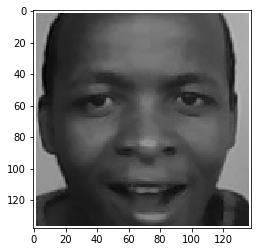

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

base_dir = '/home/tech-iguana/Documents/facial_stuff/tf_facial_model/images/train'

CATEGORIES = ["albertndege", "francisngethe",  "johnnzuki", "moseskinyua", "ronaldsamuel", "ashleywangare",  "harrysuter", "keithmartin", "patrickwainaina", "tracywanjiku", "elviswahome", "joebrian", "kennedythiga", "pricechiuri", "emmanuel", "johnnjoroge", "lynnsaidi", "richardwamalwa"]

for category in CATEGORIES:
    path = os.path.join(base_dir, category) #with the iterator named cartegory we are able to loop over files of diffrent people.
    for img in os.listdir(path):  # gets the images of diffrent people store in diffrent folders
        img_array = cv2.imread(os.path.join(path,img))  # convert to array cv.CV_BGR2GRAY
        #plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY))  # shows the image in a scale ##, cmap='gray'
        plt.imshow(img_array)
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

In [3]:
#print(img_array)

In [4]:
print(img_array.shape)

(138, 138, 3)


#### Resizing the images

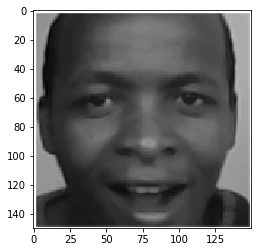

In [5]:
IMG_SIZE = 150

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
#plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2GRAY)) ## COLOR_BGR2RGB ## cmap='gray'
plt.imshow(new_array)
plt.show()

In [6]:
print(new_array.shape)

(150, 150, 3)


### Creating training data

In [7]:
training_data = []  

def create_training_data():
    for category in CATEGORIES: 

        path = os.path.join(base_dir, category)  # create path to diffrent folders of diffrent people that we want to use for the training set
        class_num = CATEGORIES.index(category)  # get an index for each cartegory
        for img in tqdm(os.listdir(path)):  # iterate over each images of diffrent people in diffrent folders
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array   #,cv2.IMREAD_GRAYSCALE
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass

create_training_data()

print(len(training_data))

100%|██████████| 224/224 [00:01<00:00, 164.49it/s] 

4100


In [8]:
import random

random.shuffle(training_data)

In [9]:
#for sample in training_data[:10]:
 #   print(sample[1])

In [10]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X)
y = np.array(y)


In [11]:
X.shape

(4100, 150, 150, 3)

In [12]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [13]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

## Transfer Learning

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16

#img_height = img_width = 100 
#channels = 3


#datagen = ImageDataGenerator(rescale=1.0/255)
model = VGG16(weights='imagenet', include_top = False, input_shape = (150, 150, 3))           

In [15]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras import optimizers

Using TensorFlow backend.


In [17]:
# CREATE A "REAL" MODEL FROM VGG16
# BY COPYING ALL THE LAYERS OF VGG16
new_model = tensorflow.keras.Sequential()
for l in model.layers:
    model.trainable = False
    new_model.add(l)


In [18]:
new_model.add(Flatten())
new_model.add(Dense(256, activation='relu'))
new_model.add(Dense(18, activation='softmax'))

In [19]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)       2

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [21]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 4100 images belonging to 18 classes.


In [22]:
for data_batch, labels_batch in train_generator:

    print('data batch shape:', data_batch.shape)

    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 150, 150, 3)
labels batch shape: (32, 18)


#### validation data

In [23]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_dir = '/home/tech-iguana/Documents/facial_stuff/tf_facial_model/images/validation'

In [24]:
validation_generator = validation_datagen.flow_from_directory(
validation_dir,
target_size=(150, 150),
batch_size=32,
class_mode='categorical')

Found 323 images belonging to 18 classes.


In [25]:
new_model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

In [26]:
history = new_model.fit_generator(
        train_generator,
        steps_per_epoch=30,
        epochs=30, 
        validation_data = validation_generator,
        validation_steps=50)

Epoch 1/30
30/30 [==============================] - 652s 22s/step - loss: 3.1134 - accuracy: 0.2531 - val_loss: 1.4445 - val_accuracy: 0.5782
Epoch 2/30
30/30 [==============================] - 642s 21s/step - loss: 1.6379 - accuracy: 0.4885 - val_loss: 0.9757 - val_accuracy: 0.7500
Epoch 3/30
30/30 [==============================] - 630s 21s/step - loss: 1.0722 - accuracy: 0.6824 - val_loss: 0.6425 - val_accuracy: 0.8302
Epoch 4/30
30/30 [==============================] - 641s 21s/step - loss: 0.8726 - accuracy: 0.7427 - val_loss: 0.4133 - val_accuracy: 0.8834
Epoch 5/30
30/30 [==============================] - 642s 21s/step - loss: 0.6271 - accuracy: 0.8208 - val_loss: 0.2972 - val_accuracy: 0.9602
Epoch 6/30
30/30 [==============================] - 629s 21s/step - loss: 0.5036 - accuracy: 0.8358 - val_loss: 0.2874 - val_accuracy: 0.9225
Epoch 7/30
30/30 [==============================] - 636s 21s/step - loss: 0.4592 - accuracy: 0.8708 - val_loss: 0.3167 - val_accuracy: 0.9212
Epoch 

In [27]:
 new_model.save('4.2 facial recognition model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: 4.2 facial recognition model/assets


#### Plotting the results

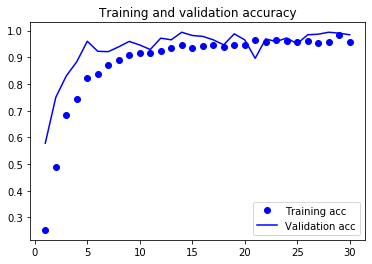

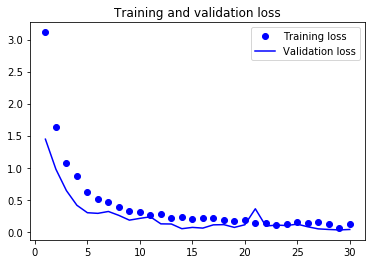

In [29]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Testing the model

In [30]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_dir =  '/home/tech-iguana/Documents/facial_stuff/tf_facial_model/images/test'

test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(150, 150),
batch_size=20,
class_mode='categorical')
test_loss, test_acc = new_model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 162 images belonging to 18 classes.
test acc: 0.96813184


In [44]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img = image.load_img(test_image, target_size=(150, 150))


img = image.load_img(test_image, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [45]:
preds = new_model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (1, 18)

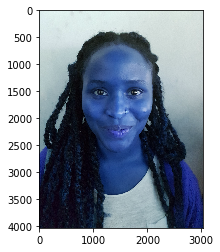

In [28]:
base_directory = '/home/tech-iguana/Documents/facial_stuff/tf_facial_model/images/test'

CATEGORIES = ["ashleywangare", "danielmatheka", "flavintitus", "harrysuter", "kennedythiga",  "moseskinyua", "richardwamalwa", "shaphneil", "tracywanjiku", "collinskorir", "elviswahome", "floraonyango", "johnnzuki", "lynnsaidi", "pricechiuri", "royngacha", "tabbynjeri", "danielwambugu",  "ernestmucheru", "georgemwaura", "josephnyangaresi",  "morrisnduvah",  "ramahashim", "safia", "timothymanyonge"]


for category in CATEGORIES:
    path = os.path.join(base_directory, category) #with the iterator named cartegory we are able to loop over files of diffrent people.
    for img in os.listdir(path):  # gets the images of diffrent people store in diffrent folders
        img_array = cv2.imread(os.path.join(path,img))  # convert to array cv.CV_BGR2GRAY
        plt.imshow(img_array) #,cv2.COLOR_BGR2RGB  # shows the image in a scale ##, cmap='gray' 
        #plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

### Reshaping test data

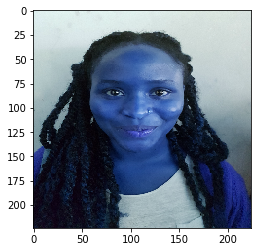

In [30]:
IMG_SIZE = 224

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)  ## cmap='gray'
plt.show()

In [54]:
print(new_array.shape)

(224, 224, 3)


### Creating test data

In [23]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import numpy as np
import os


base_directory = '/home/tech-iguana/Documents/facial_stuff/tf_facial_model/images/test'

 
CATEGORIES = ["ashleywangare", "danielmatheka", "flavintitus", "harrysuter", "kennedythiga",  "moseskinyua", "richardwamalwa", "tracywanjiku", "elviswahome", "floraonyango", "johnnzuki", "lynnsaidi", "pricechiuri", "royngacha", "tabbynjeri", "danielwambugu",  "ernestmucheru", "georgemwaura", "josephnyangaresi",  "morrisnduvah",  "ramahashim", "safia", "timothymanyonge"]
IMG_SIZE = 224

test_data = []  

def create_test_data():
    for category in CATEGORIES: 

        path = os.path.join(base_directory, category)  # create path to diffrent folders of diffrent people that we want to use for the training set
        class_nums = CATEGORIES.index(category)  # get an index for each cartegory
        for img in tqdm(os.listdir(path)):  # iterate over each images of diffrent people in diffrent folders
            try:
                img_in_array = cv2.imread(os.path.join(path,img))  # convert to array   #,cv2.IMREAD_GRAYSCALE
                a_new_array = cv2.resize(img_in_array, (224, 224))  # resize to normalize data size
                test_data.append([a_new_array, class_nums])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_test_data()

print(len(test_data)) 



#prediction = prediction.data.numpy().argmax()  # Our prediction will be the index of the class label with the largest value.
#print labels[prediction]

#features = model.predict(x)
#features

Using TensorFlow backend.
100%|██████████| 6/6 [00:01<00:00,  3.71it/s]

206


In [22]:
type(test_data)

NameError: name 'test_data' is not defined

In [26]:
X_test = []
y_test = []

for features,label in test_data:
    X_test.append(features)
    y_test.append(label)
    

#print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))


xx = np.array(X_test)     #.reshape(-1, IMG_SIZE, IMG_SIZE)    #reshape((333, 50, 50))
yy = np.array(y_test)


In [27]:
xx.shape

(206, 224, 224, 3)

In [28]:
type(xx)

numpy.ndarray

In [30]:
score = new_model.evaluate(xx, yy, verbose=0)

InvalidArgumentError:  Received a label value of 23 which is outside the valid range of [0, 20).  Label values: 19 19 20 20 21 21 21 21 21 21 21 21 21 21 21 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 23
	 [[node loss/dense_8_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at /home/tech-iguana/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_distributed_function_5195]

Function call stack:
distributed_function


In [ ]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [48]:

CATEGORIESS = ["ashleywangare", "danielmatheka", "flavintitus", "harrysuter", "kennedythiga",  "moseskinyua", "richardwamalwa", "shaphneil", "tracywanjiku", "collinskorir", "elviswahome", "floraonyango", "johnnzuki", "lynnsaidi", "pricechiuri", "royngacha", "tabbynjeri", "danielwambugu",  "ernestmucheru", "georgemwaura", "josephnyangaresi",  "morrisnduvah",  "ramahashim", "safia", "timothymanyonge"]


for categorys in CATEGORIESS:
    
    path = os.path.join(base_directory, categorys) #with the iterator named cartegory we are able to loop over files of diffrent people.
    
    
    for imagee in os.listdir(path):  # gets the images of diffrent people store in diffrent folders
        the_img_array = cv2.imread(os.path.join(path,imagee))  # convert to array cv.CV_BGR2GRAY
        aa_new_array = cv2.resize(the_img_array, (224, 224))  # resize to normalize data size

        #print(type(the_img_array))
        #img = load_img(the_img_array, target_size=(50, 50))
        #a = image.img_to_array(the_img_array)
        
        b = np.expand_dims(aa_new_array, axis=0)
        c = preprocess_input(b)
        #c.
        break  # we just want one for now so break
    break  #...and one more!

    

In [41]:
predictions = new_model.predict(c)


In [42]:
print(predictions)


[[0.03830478 0.04303961 0.03891935 0.04153781 0.03880183 0.03833232
  0.0393182  0.04405485 0.04075618 0.04058973 0.03879287 0.03806081
  0.03691208 0.04175521 0.04002413 0.03959535 0.04258013 0.0429209
  0.03904578 0.04133313 0.03892282 0.03905252 0.03708053 0.04106342
  0.03920572]]


In [43]:
import numpy as np

print(np.argmax(predictions))

7


In [44]:
plt.imshow(c[7],cmap=plt.cm.binary)
plt.show()

IndexError: index 7 is out of bounds for axis 0 with size 1

In [14]:
print("Prediction: {}".format(tf.argmax(features, axis=1)))
print("    Labels: {}".format(y))

Prediction: [[[0 0 0 ... 0 0 0]
  [0 0 6 ... 5 5 0]
  [5 5 0 ... 2 5 0]
  ...
  [0 6 0 ... 2 0 0]
  [0 0 0 ... 2 0 5]
  [0 0 0 ... 2 0 5]]]
    Labels: [2 3 4 4 1 2 1 6 2 4 6 9 9 2 8 9 0 4 0 4 8 5 2 2 3 0 1 2 2 1 8 0 4 0 4 4 8
 8 0 2 0 1 4 0 5 5 4 0 0 0 9 0 4 8 2 1 8 1 1 0 2 0 4 8 3 2 8 4 3 8 2 2 8 2
 2 6 4 4 0 8 1 8 1 1 3 2 8 8 2 8 0 8 3 0 8 8 1 5 1 4 4 8 2 5 1 7 0 8 8 8 5
 1 2 4 1 8 1 8 0 1 0 6 1 8 8 7 6 4 2 1 3 4 0 6 3 8 1 8 3 2 0 8 4 3 8 9 8 3
 2 0 4 4 6 7 4 0 0 2 2 1 8 2 3 3 0 2 8 2 2 1 2 3 4 1 2 2 2 2 4 3 0 1 0 4 9
 5 4 8 4 8 6 5 3 0 2 2 4 8 0 5 8 4 2 4 8 0 3 8 4 8 0 8 8 8 1 0 4 0 0 0 2 4]


In [33]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

import pickle

pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0

model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.5))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, y, batch_size=32, epochs=50, validation_split=0.8)

Train on 44 samples, validate on 178 samples
Epoch 1/50
44/44 [==============================] - 4s 98ms/sample - loss: 15.0590 - accuracy: 0.0909 - val_loss: 16.0787 - val_accuracy: 0.1180
Epoch 2/50
44/44 [==============================] - 2s 47ms/sample - loss: 13.3409 - accuracy: 0.1136 - val_loss: 16.0787 - val_accuracy: 0.1180
Epoch 3/50
44/44 [==============================] - 2s 54ms/sample - loss: 13.3409 - accuracy: 0.1136 - val_loss: 16.0787 - val_accuracy: 0.1180
Epoch 4/50
44/44 [==============================] - 2s 46ms/sample - loss: 13.3409 - accuracy: 0.1136 - val_loss: 16.0787 - val_accuracy: 0.1180
Epoch 5/50
44/44 [==============================] - 2s 50ms/sample - loss: 13.3409 - accuracy: 0.1136 - val_loss: 16.0787 - val_accuracy: 0.1180
Epoch 6/50
44/44 [==============================] - 2s 47ms/sample - loss: 13.3409 - accuracy: 0.1136 - val_loss: 16.0787 - val_accuracy: 0.1180
Epoch 7/50
44/44 [==============================] - 2s 47ms/sample - loss: 13.3409 - 

KeyboardInterrupt: 

In [29]:
model.output_shape

(None, 3, 3, 512)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 256)       2560      
_________________________________________________________________
activation (Activation)      (None, 48, 48, 256)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 256)       590080    
_________________________________________________________________
activation_1 (Activation)    (None, 22, 22, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 256)       0

In [14]:
model.save('attendancefacialmodel')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: attendancefacialmodel/assets


 # Ignore this part

In [49]:
import cv2
import tensorflow as tf

CATEGORIES = ["keith", "martin","keithmartin", "jay", "rodney", "florence", "denzel", "slyvia", "albert", "luidgi"]

def prepare(filepath):
    IMG_SIZE = 50  
    img_array = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [50]:
model = tf.keras.models.load_model("attendancefacialmodel")

In [56]:
base_dir = '/home/tech-iguana/Documents/facial_stuff/tf_facial_model/images/test'

img = os.path.join(base_dir,'martin,2019.5.jpg') 

IMG_SIZE = 50  
img_array = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

prediction = model.predict([prepare('new_array')])

#return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)



#print(prediction)  # will be a list in a list.
#print(CATEGORIES[int(prediction[0][0])]

ValueError: Python inputs incompatible with input_signature:
  inputs: (
    Tensor("IteratorGetNext:0", shape=(None, 50, 50, 1), dtype=uint8))
  input_signature: (
    TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None))